In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from jax import random
from PIL import Image
from splotch import get_input_data, register, run_nuts, run_svi, savagedickey
from splotch.visualization import plot_coefficients, plot_rates_on_slides, plot_rates_in_common_coordinate_system, plot_annotations_in_common_coordinate_system

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"

Image.MAX_IMAGE_PIXELS = 1000000000

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [2]:
splotch_input_data = get_input_data("metadata.tsv", 1, min_detection_rate=0.1, max_num_spots_per_tissue_section=400)

In [3]:
key = random.PRNGKey(0)
key, key_ = random.split(key, 2)
register(key_, splotch_input_data, num_steps=10_000)

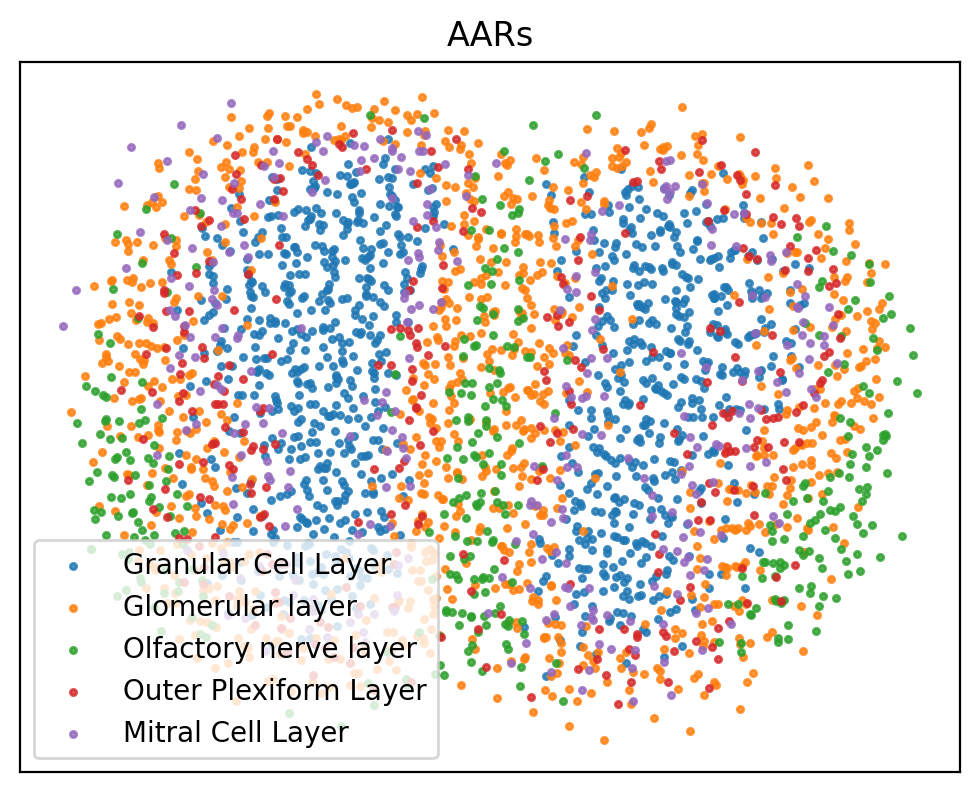

In [4]:
plot_annotations_in_common_coordinate_system(splotch_input_data);

In [5]:
splotch_input_data.metadata.groupby(
    ["level_1"], observed=True
).size().reset_index(name="num_spots").head()

level_1  num_spots
0       A       1061
1       B        263
2       C        454
3       D        452
4       E        813

In [6]:
splotch_input_data.metadata.groupby(
    ["level_1", "aar"], observed=True
).size().reset_index(name="num_spots").head()

level_1                    aar  num_spots
0       A       Glomerular layer        336
1       A    Granular Cell Layer        365
2       A      Mitral Cell Layer         99
3       A  Olfactory nerve layer        137
4       A  Outer Plexiform Layer        124

## NUTS

In [7]:
key = random.PRNGKey(0)
key, key_ = random.split(key)

splotch_result_nuts = run_nuts(
    key_,
    ["Camk4", "Tubb6"],
    splotch_input_data,
    map_method="pmap",
    num_warmup=1_000,
    num_samples=1_000,
    num_chains=4,
)

2023-12-15 19:41:51.254698: E external/xla/xla/service/collective_ops_utils.h:260] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{rank=0, element_count=12172000, type=F32, rendezvous_key=RendezvousKey{run_id=RunId: 4648, global_devices=[4,5,6,7], num_local_participants=4, collective_op_kind=cross_replica, op_id=321}} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 4648, global_devices=[4,5,6,7], num_local_participants=4, collective_op_kind=cross_replica, op_id=321}
2023-12-15 19:41:51.833140: E external/xla/xla/service/collective_ops_utils.h:260] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{rank=2, element_count=12172000, type=F32, rendezvous_key=RendezvousKey{run_id=RunId: 4648, global_devices=[4,5,6,7], num_local_participants=4, collective_op_kind=cross_replica, op_id=321}} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=

In [8]:
pd.concat(
    [
        splotch_result_nuts.inference_metrics["summary"][k].query("r_hat > 1.05")
        for k in splotch_result_nuts.inference_metrics["summary"]
    ],
    axis=0,
)

Empty DataFrame
Columns: [mean, std, median, 5.0%, 95.0%, n_eff, r_hat]
Index: []

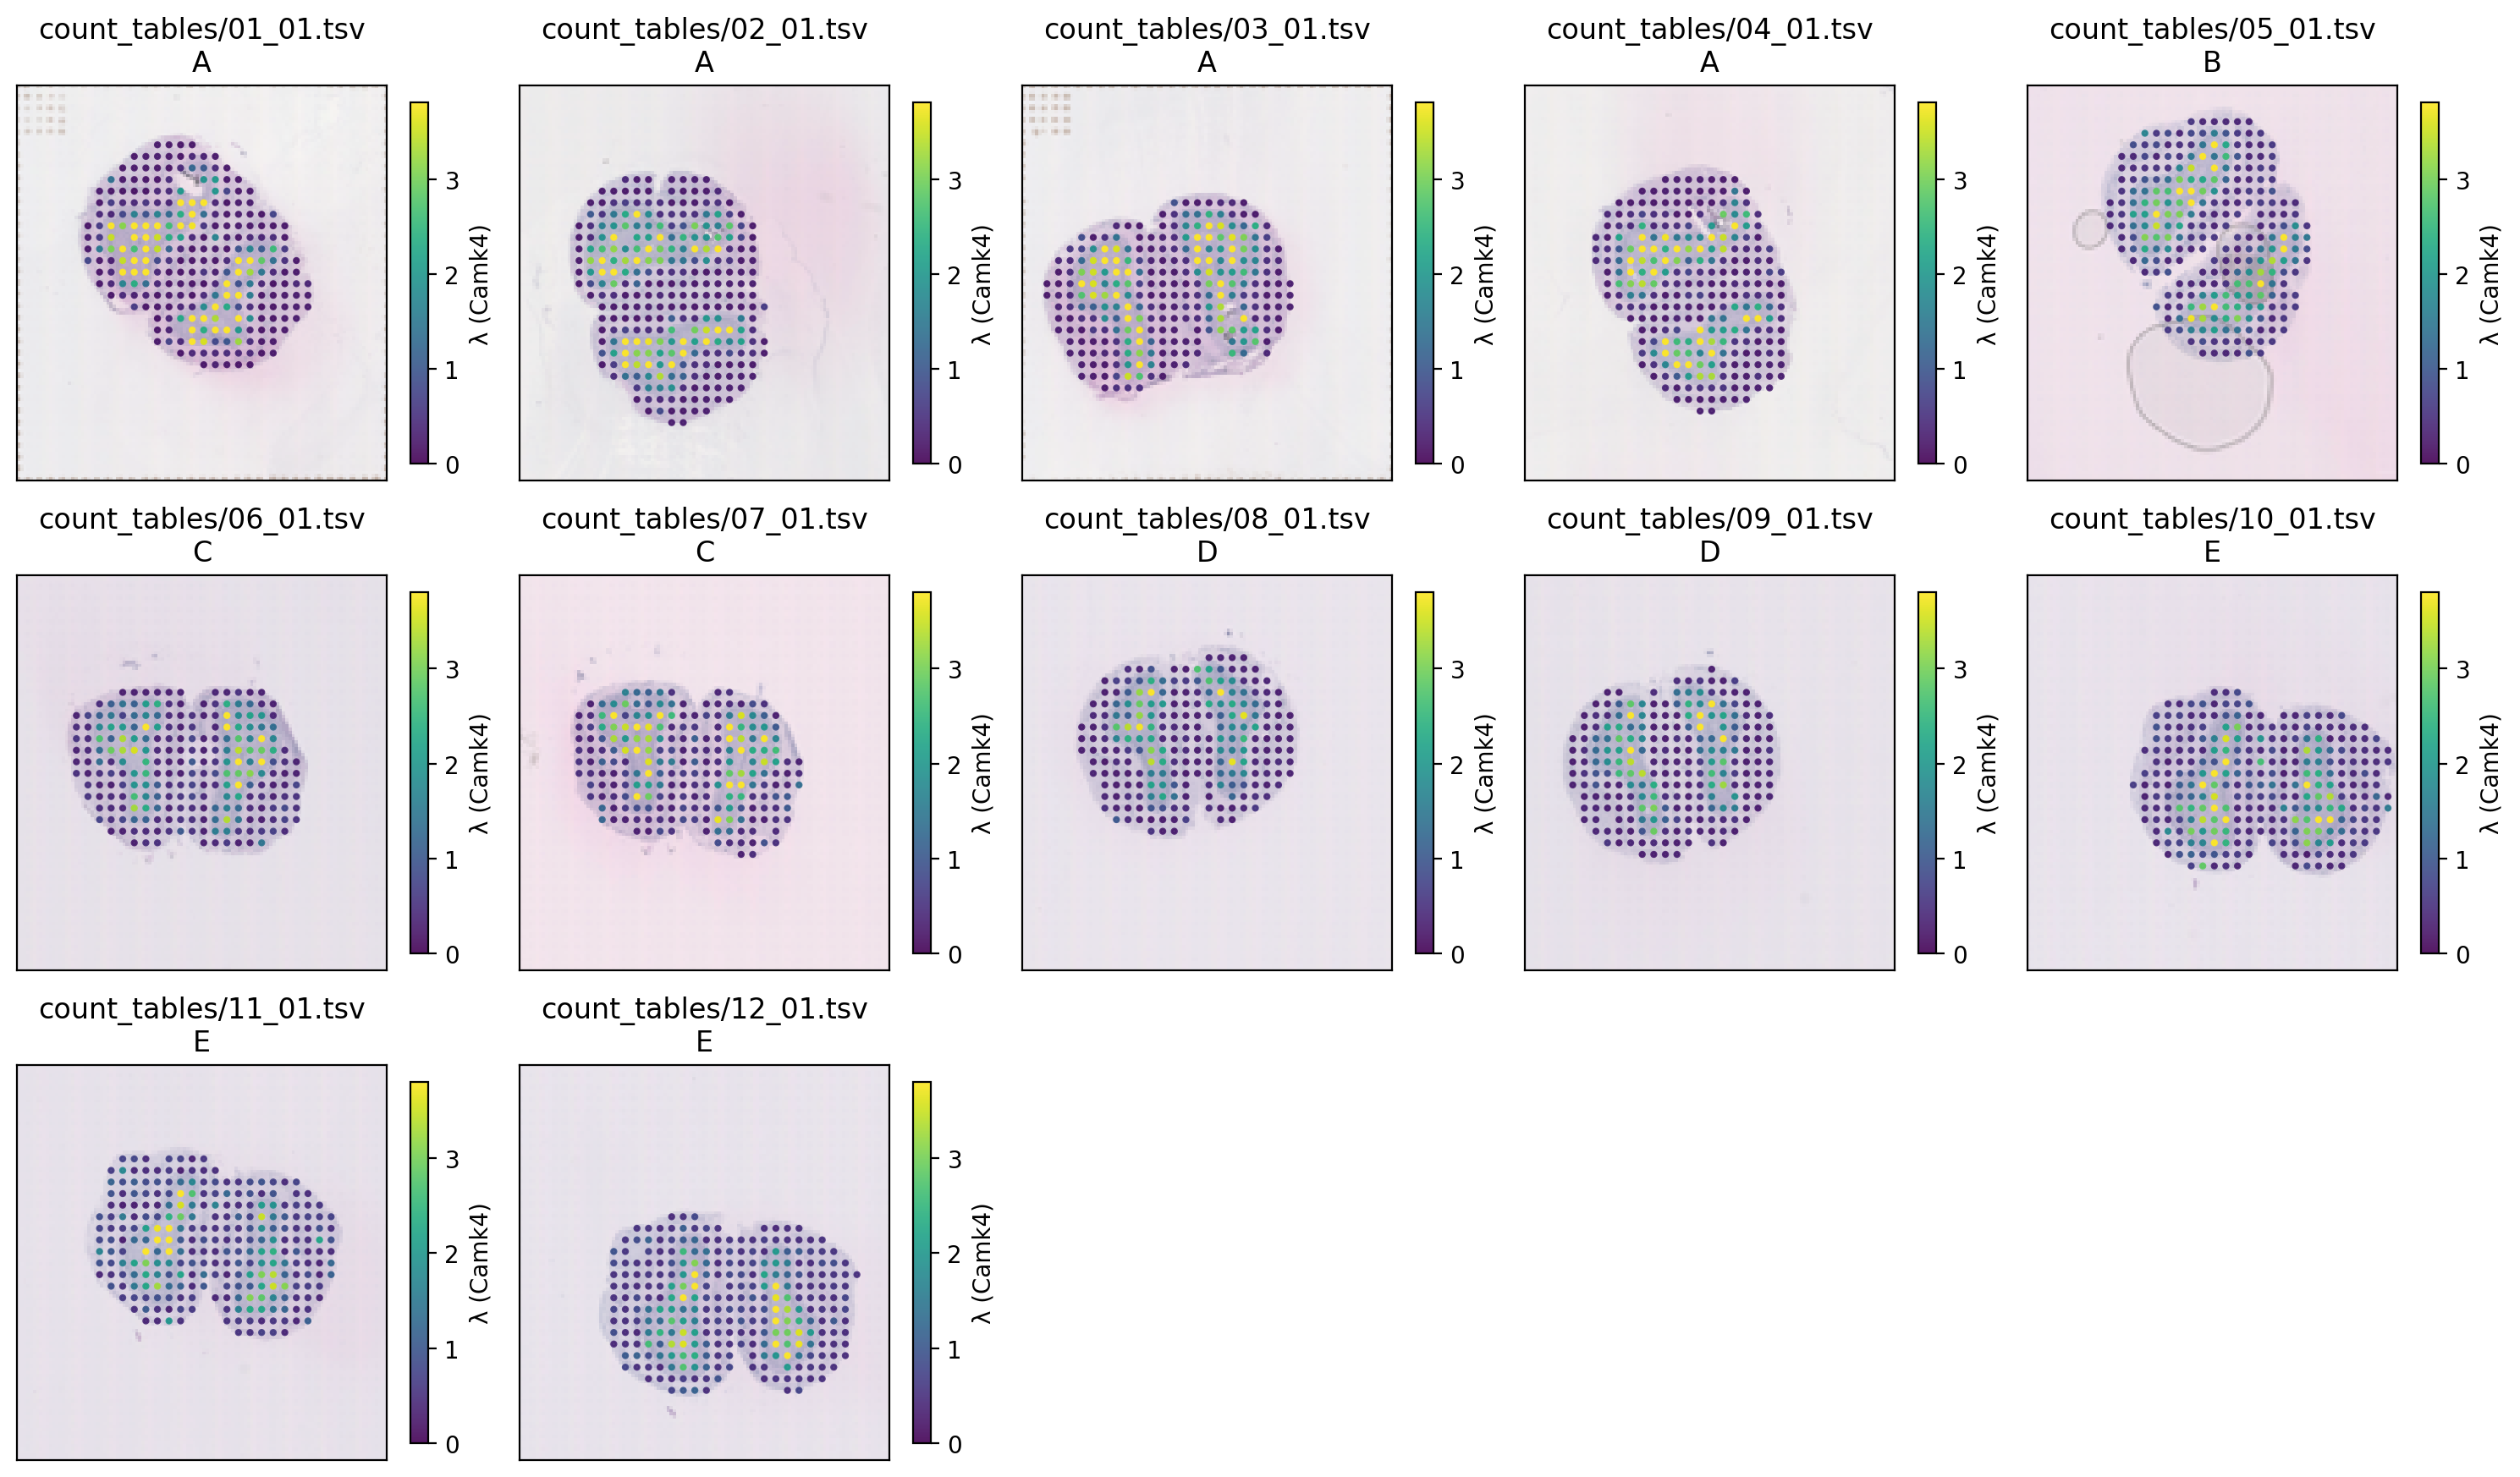

In [9]:
gene = "Camk4"

plot_rates_on_slides(splotch_result_nuts, gene);

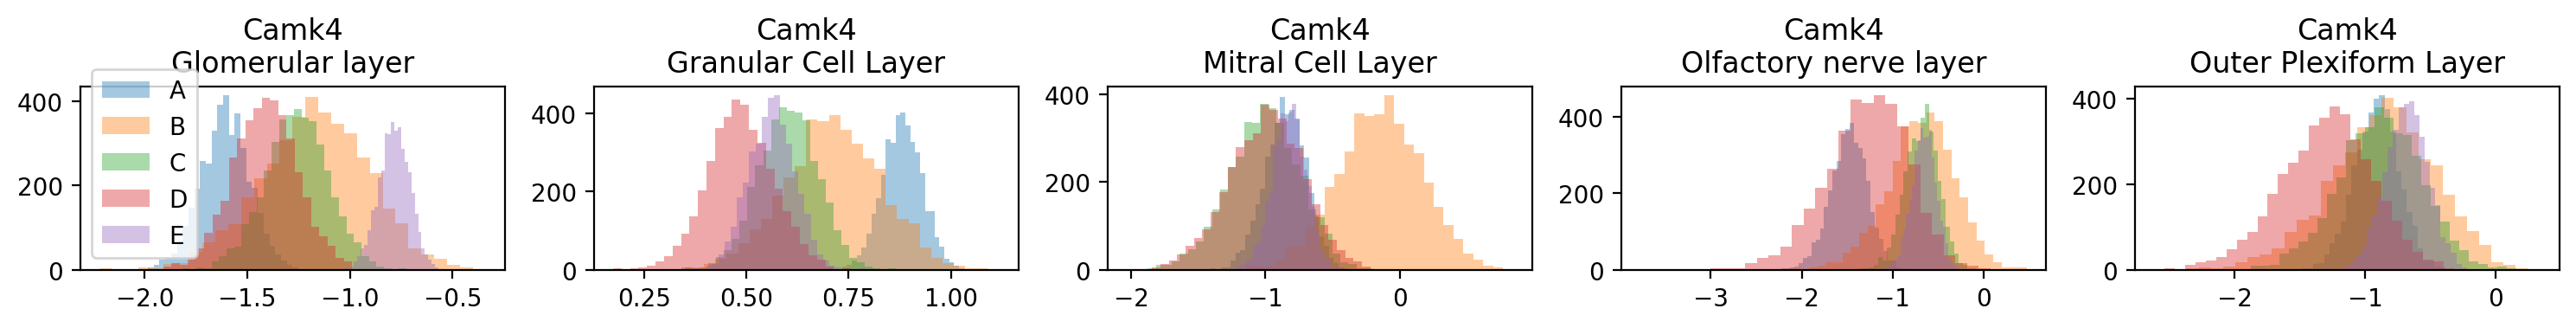

In [10]:
gene = "Camk4"

plot_coefficients(splotch_input_data, splotch_result_nuts, gene);

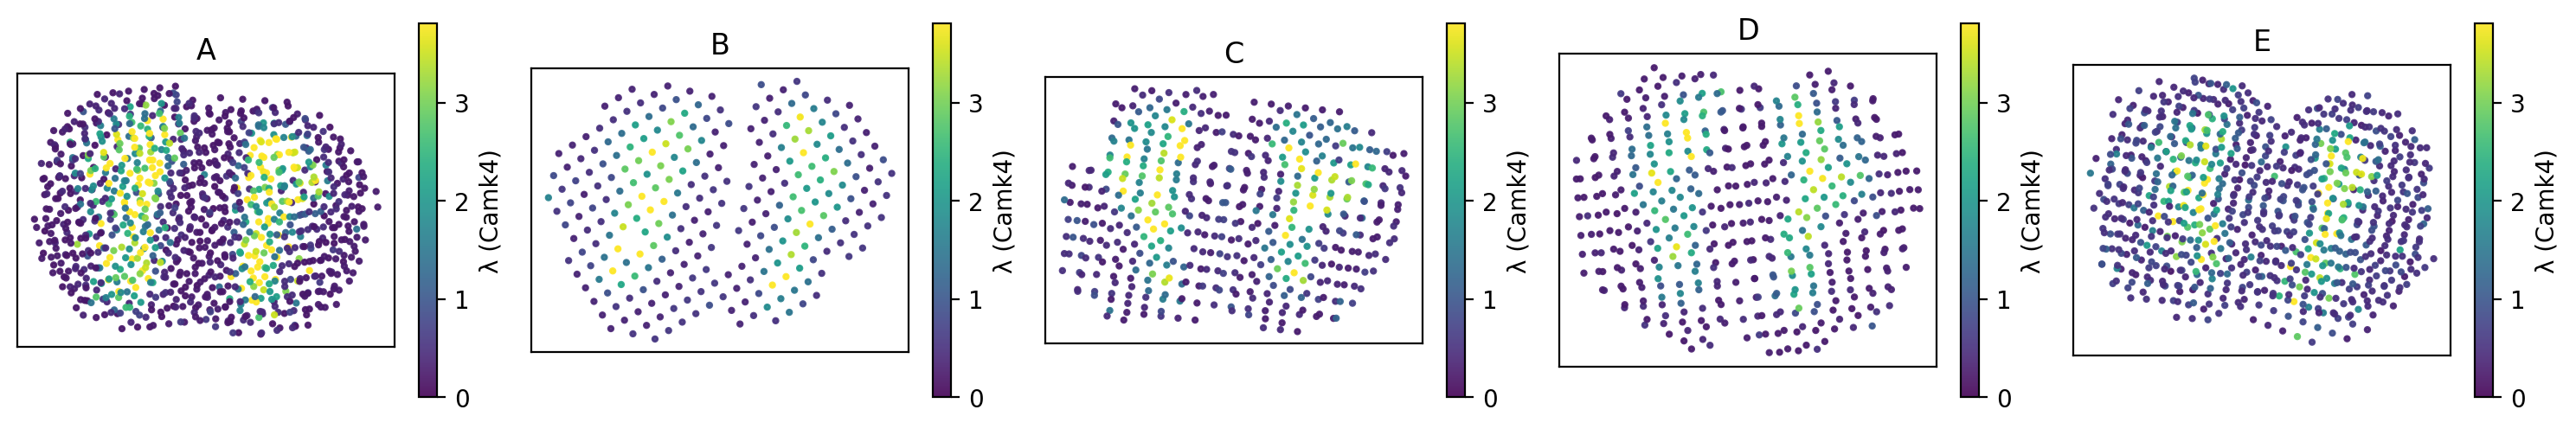

In [11]:
gene = "Camk4"

plot_rates_in_common_coordinate_system(splotch_result_nuts, gene);

## SVI

In [12]:
key = random.PRNGKey(0)
key, key_ = random.split(key)
splotch_result_svi = run_svi(
    key,
    ["Camk4"],
    splotch_input_data,
    map_method="map",
    num_steps=10_000,
    num_samples=1_000,
)

Text(0.5, 0, 'Iteration')

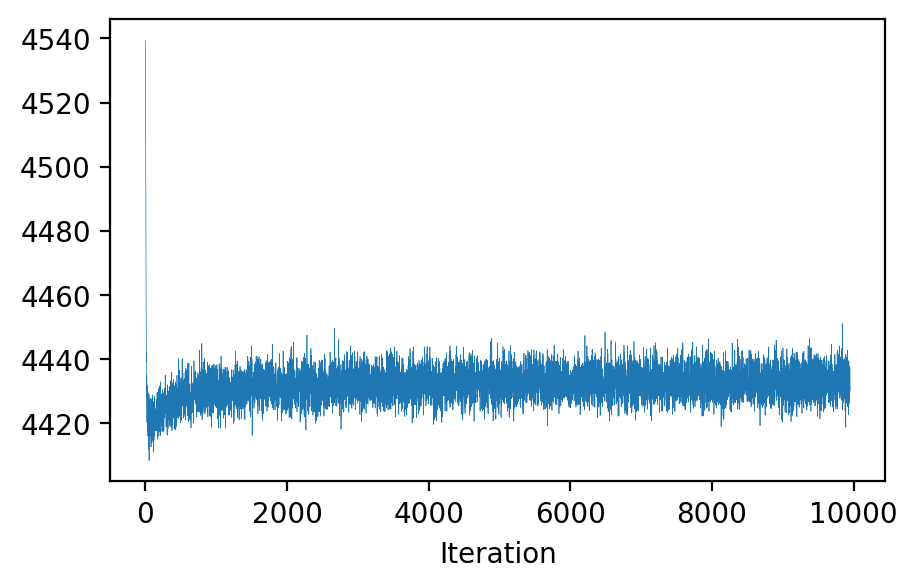

In [13]:
fig = plt.figure()
fig.set_size_inches(5, 3)

ax = fig.add_subplot(1, 1, 1)

ax.plot(splotch_result_svi.inference_metrics["losses"][0, 50:], lw=0.25)
ax.set_xlabel("Iteration")

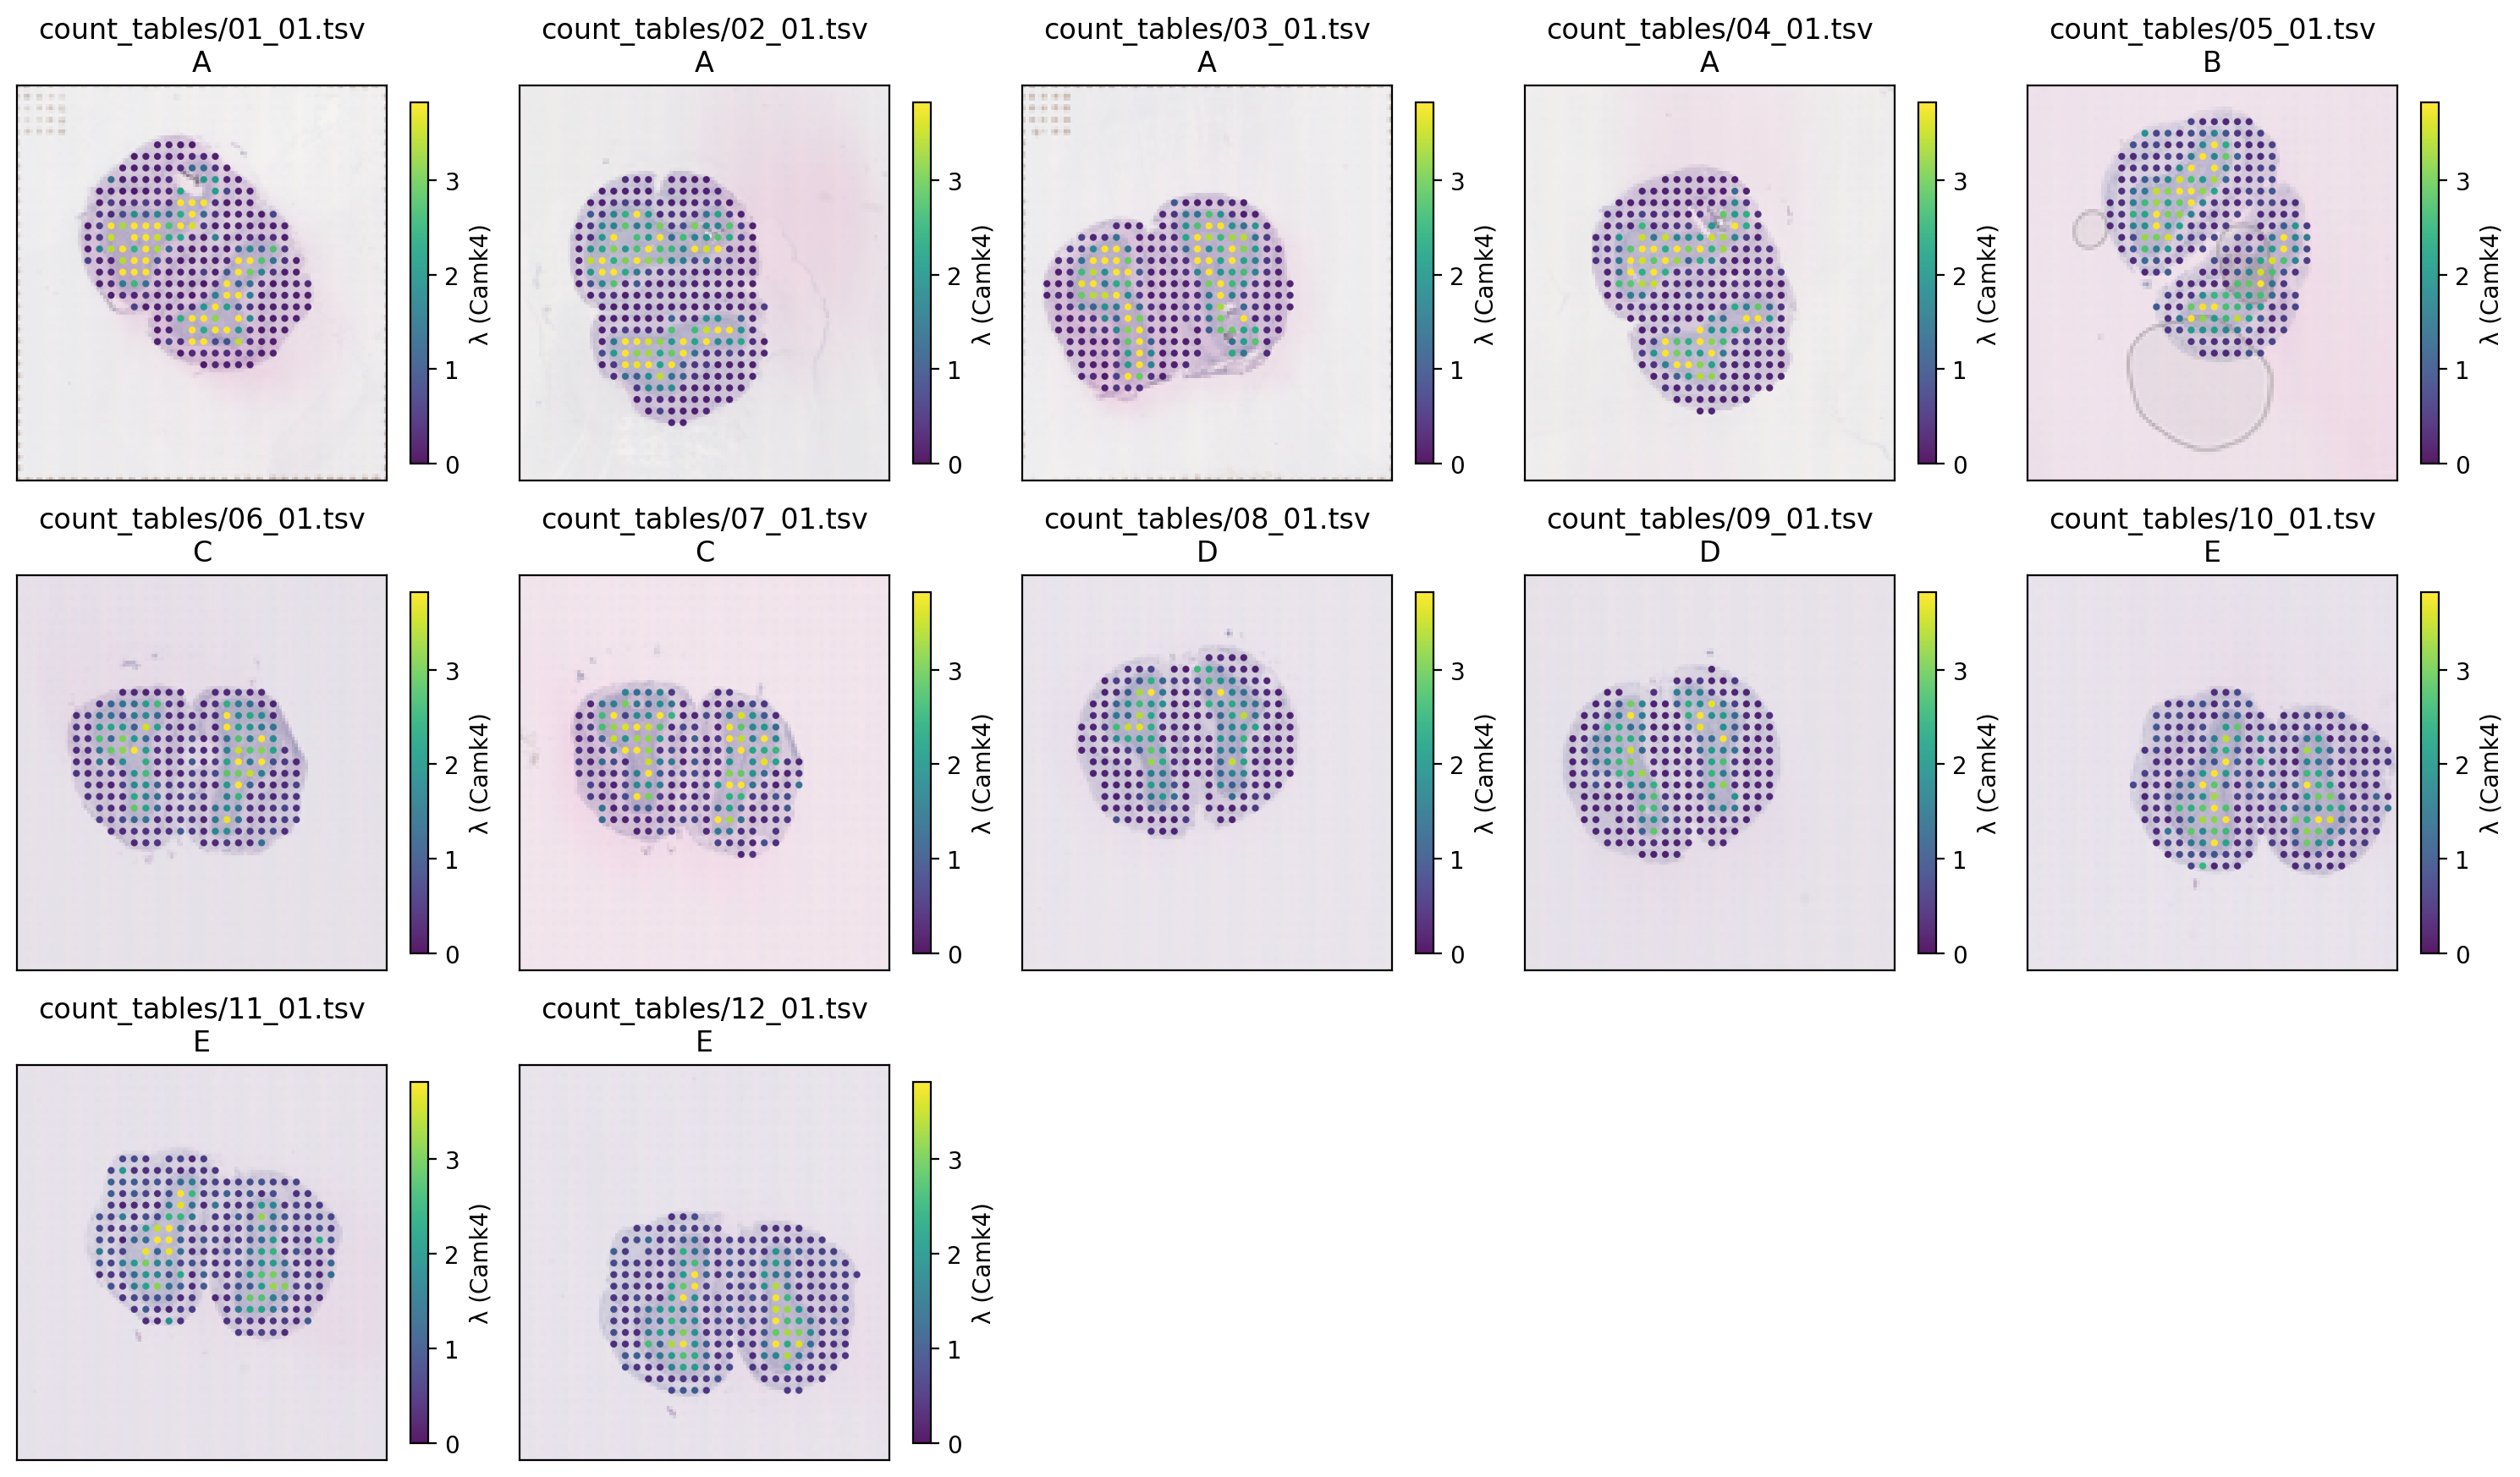

In [14]:
gene = "Camk4"

plot_rates_on_slides(splotch_result_svi, gene);

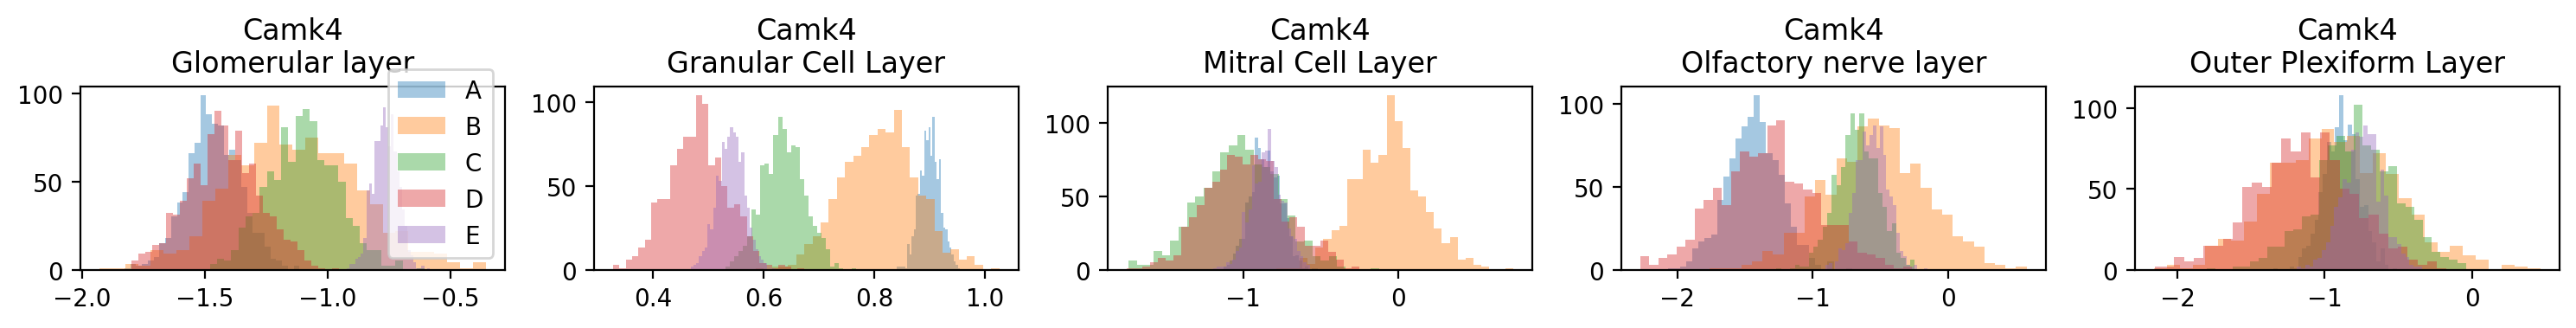

In [15]:
gene = "Camk4"

plot_coefficients(splotch_input_data, splotch_result_svi, gene);

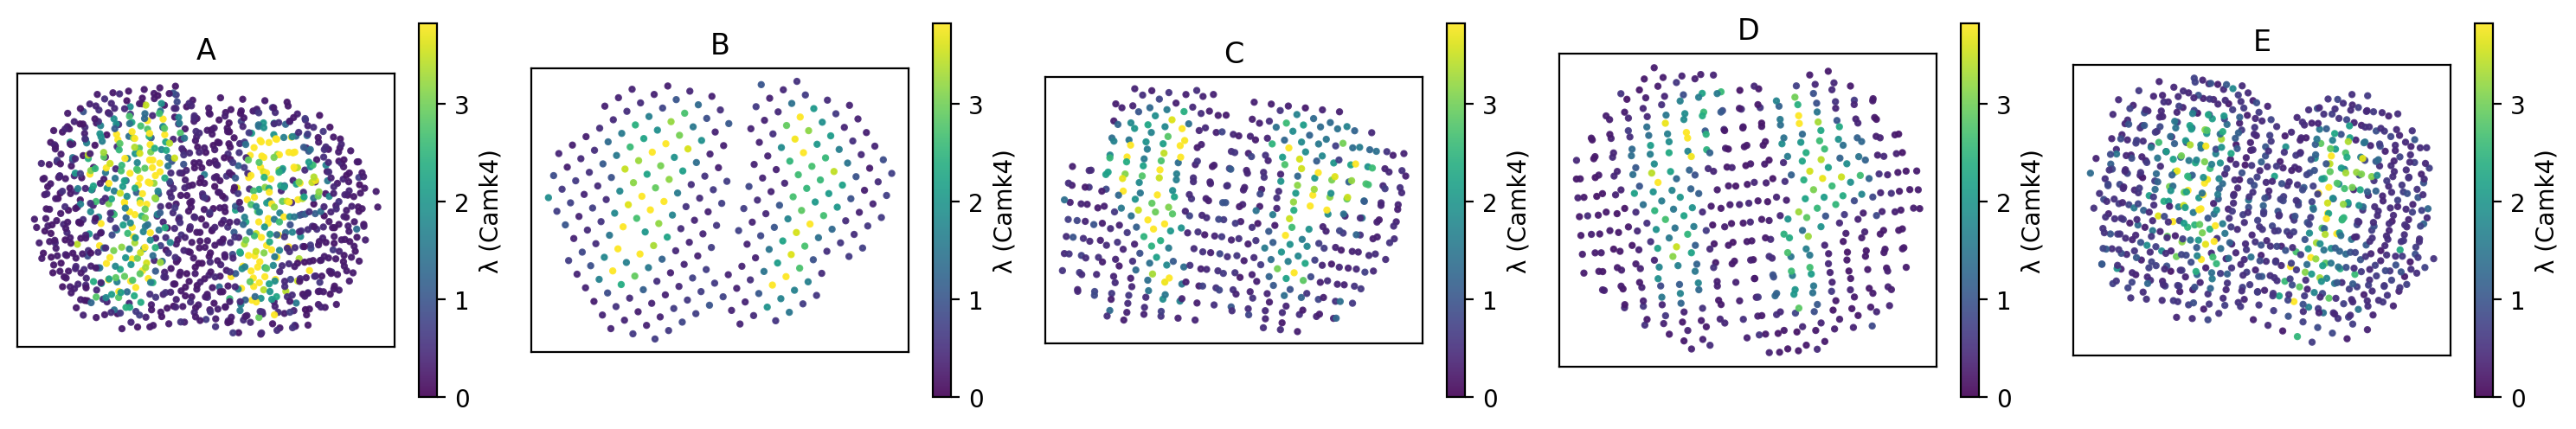

In [16]:
gene = "Camk4"

plot_rates_in_common_coordinate_system(splotch_result_svi, gene);